# Heart Failure Readmission Analysis

This notebook focuses on analyzing features that could predict 30-day readmissions for heart failure patients.

## Analysis Goals:
1. Identify key predictive features
2. Analyze demographics and clinical patterns
3. Create target variable (30-day readmission)
4. Visualize relationships between features
5. Generate insights for model development

In [14]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Add the src directory to Python path
notebook_dir = Path(r'c:/Users/tyagi/Desktop/heartbyte/notebooks')
src_dir = notebook_dir.parent / 'src'
sys.path.append(str(src_dir))

from data_loader import MIMICDataLoader

# Configure plotting
%matplotlib inline
plt.style.use('default')  # Use default style instead of seaborn
sns.set_theme()  # Apply seaborn styling

In [15]:
# Load heart failure patient data
loader = MIMICDataLoader()
loader.load_data()
hf_patients, hf_admissions, hf_diagnoses, hf_procedures = loader.filter_heart_failure_patients()

Loaded 58976 admissions
Loaded 46520 patients
Loaded 651047 diagnoses
Loaded 240095 procedures
Found 78963 procedures for heart failure patients
Found 10272 patients with heart failure
These patients had 16756 admissions


## 1. Create Target Variable: 30-day Readmission

First, we'll identify readmissions by comparing admission dates for each patient.

In [16]:
def calculate_readmissions(admissions_df):
    # Sort admissions by patient and date
    admissions_df = admissions_df.sort_values(['subject_id', 'admittime'])
    
    # Convert admission and discharge times to datetime
    admissions_df['admittime'] = pd.to_datetime(admissions_df['admittime'])
    admissions_df['dischtime'] = pd.to_datetime(admissions_df['dischtime'])
    
    # Calculate days until next admission for each patient
    admissions_df['next_admittime'] = admissions_df.groupby('subject_id')['admittime'].shift(-1)
    admissions_df['days_to_next_admission'] = (admissions_df['next_admittime'] - admissions_df['dischtime']).dt.total_seconds() / (24*60*60)
    
    # Mark readmissions (1 if readmitted within 30 days, 0 if not)
    admissions_df['is_readmission'] = (admissions_df['days_to_next_admission'] <= 30).astype(int)
    
    return admissions_df

# Calculate readmissions
hf_admissions = calculate_readmissions(hf_admissions)

# Display readmission statistics
readmission_rate = hf_admissions['is_readmission'].mean() * 100
print(f"30-day readmission rate: {readmission_rate:.2f}%")
print(f"Total readmissions: {hf_admissions['is_readmission'].sum()}")

30-day readmission rate: 9.75%
Total readmissions: 1634


## 2. Feature Engineering

Let's create relevant features for our analysis:

In [17]:
def create_features(patients, admissions, diagnoses, procedures):
    # Start with admissions data
    features = admissions.copy()
    
    # Add patient demographics and calculate age
    patient_features = patients[['subject_id']].copy()
    
    # Add gender if available
    if 'gender' in patients.columns:
        patient_features['gender'] = patients['gender']
        features = features.merge(patient_features[['subject_id', 'gender']], 
                                on='subject_id', 
                                how='left')
    
    # Calculate age if DOB is available
    if 'dob' in patients.columns and 'admittime' in admissions.columns:
        # Convert dates to datetime
        patient_features['dob'] = pd.to_datetime(patients['dob'])
        features['admittime'] = pd.to_datetime(features['admittime'])
        
        # Calculate age using year difference then adjust for month and day
        features = features.merge(patient_features[['subject_id', 'dob']], 
                                on='subject_id', 
                                how='left')
        features['age'] = features.apply(lambda x: 
            (x['admittime'].year - x['dob'].year) - 
            ((x['admittime'].month, x['admittime'].day) < 
             (x['dob'].month, x['dob'].day)), axis=1)
        
        # Drop temporary DOB column
        features = features.drop('dob', axis=1)
    
    # Calculate length of stay if discharge time is available
    if 'dischtime' in features.columns:
        features['dischtime'] = pd.to_datetime(features['dischtime'])
        features['length_of_stay'] = (features['dischtime'] - 
                                     features['admittime']).dt.total_seconds() / (24*60*60)
    
    # Calculate admission count and time since last admission
    features['admission_count'] = features.groupby('subject_id').cumcount() + 1
    
    if 'dischtime' in features.columns:
        features['prev_dischtime'] = features.groupby('subject_id')['dischtime'].shift(1)
        features['days_since_last_admission'] = (features['admittime'] - 
                                                pd.to_datetime(features['prev_dischtime'])).dt.total_seconds() / (24*60*60)
    
    # Count comorbidities per admission
    if 'hadm_id' in diagnoses.columns:
        comorbidity_counts = diagnoses.groupby('hadm_id').size().reset_index(name='num_diagnoses')
        features = features.merge(comorbidity_counts, on='hadm_id', how='left')
    
    # Count procedures per admission if available
    if procedures is not None and 'hadm_id' in procedures.columns:
        procedure_counts = procedures.groupby('hadm_id').size().reset_index(name='num_procedures')
        features = features.merge(procedure_counts, on='hadm_id', how='left')
    
    # Fill missing values
    numerical_columns = ['length_of_stay', 'days_since_last_admission', 'num_diagnoses', 'num_procedures']
    for col in numerical_columns:
        if col in features.columns:
            features[col] = features[col].fillna(0)
            
    # Print available features
    print("Available features:", features.columns.tolist())
    
    return features

# Create feature dataset
features_df = create_features(hf_patients, hf_admissions, hf_diagnoses, hf_procedures)

# Display basic statistics for available numerical features
print("\nFeature Statistics:")
print("-" * 50)
numerical_features = [col for col in ['age', 'length_of_stay', 'admission_count', 'num_diagnoses', 'num_procedures']
                     if col in features_df.columns]
print(features_df[numerical_features].describe())

Available features: ['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime', 'admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis', 'hospital_expire_flag', 'has_chartevents_data', 'next_admittime', 'days_to_next_admission', 'is_readmission', 'gender', 'age', 'length_of_stay', 'admission_count', 'prev_dischtime', 'days_since_last_admission', 'num_diagnoses', 'num_procedures']

Feature Statistics:
--------------------------------------------------
                age  length_of_stay  admission_count  num_diagnoses  \
count  16756.000000    16756.000000     16756.000000   16756.000000   
mean      89.567379       11.231073         1.914956       1.028587   
std       67.643567       11.016329         2.086660       0.619840   
min        0.000000       -0.359722         1.000000       0.000000   
25%       62.000000        4.896528         1.000000       1.00

## 3. Demographic Analysis

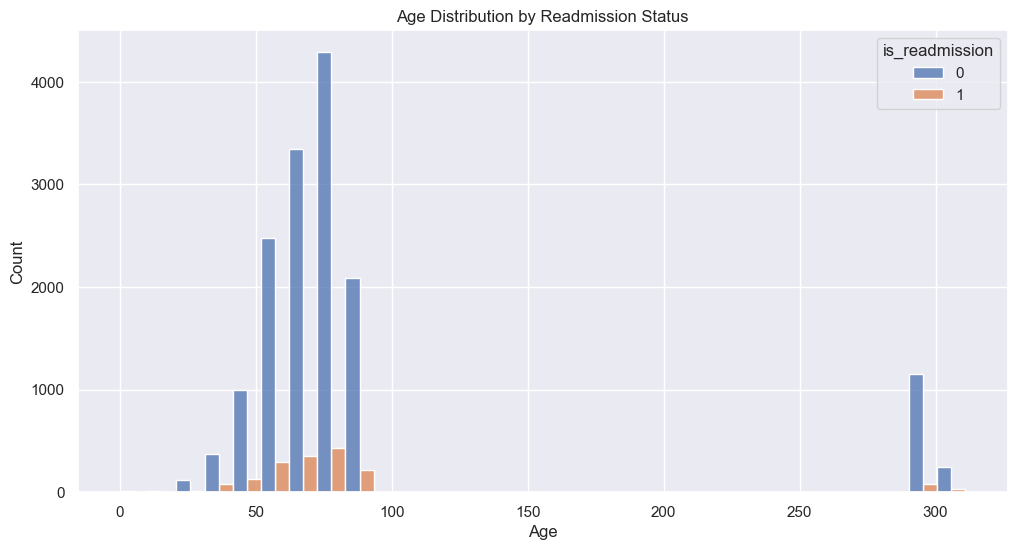


Age Statistics by Readmission Status:
                  count       mean        std  min   25%   50%   75%    max
is_readmission                                                             
0               15122.0  90.293215  68.332982  0.0  62.0  73.0  82.0  311.0
1                1634.0  82.850061  60.501134  0.0  59.0  70.0  81.0  310.0


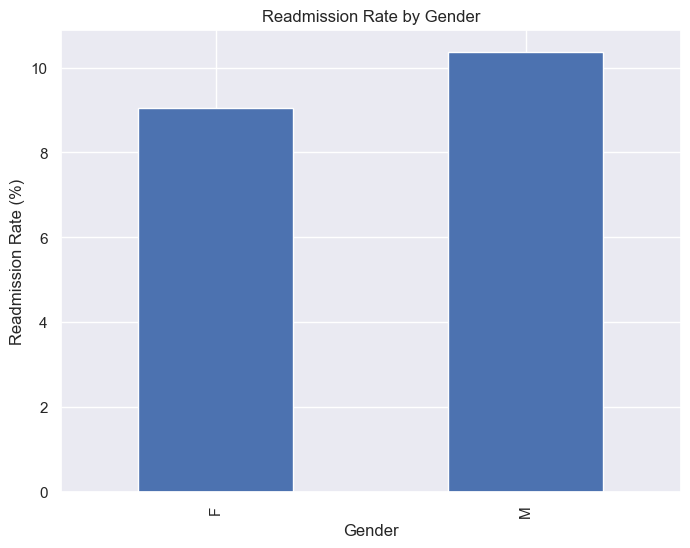


Gender Distribution:
gender
M    53.2
F    46.8
Name: proportion, dtype: float64

Readmission Rate by Gender:
gender
F     9.04
M    10.38
Name: 1, dtype: float64

Demographic Summary:
--------------------------------------------------
Total patients: 10272
Total admissions: 16756
Average admissions per patient: 1.63


In [18]:
# Age distribution by readmission status
if 'age' in features_df.columns:
    plt.figure(figsize=(12, 6))
    sns.histplot(data=features_df, x='age', hue='is_readmission', multiple="dodge", bins=30)
    plt.title('Age Distribution by Readmission Status')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.show()
    
    # Print age statistics by readmission status
    print("\nAge Statistics by Readmission Status:")
    print(features_df.groupby('is_readmission')['age'].describe())
else:
    print("Warning: Age data not available")

# Gender analysis
if 'gender' in features_df.columns:
    gender_readmission = pd.crosstab(features_df['gender'], 
                                    features_df['is_readmission'], 
                                    normalize='index') * 100

    plt.figure(figsize=(8, 6))
    gender_readmission[1].plot(kind='bar')
    plt.title('Readmission Rate by Gender')
    plt.xlabel('Gender')
    plt.ylabel('Readmission Rate (%)')
    plt.show()
    
    # Print gender distribution
    print("\nGender Distribution:")
    print(features_df['gender'].value_counts(normalize=True).mul(100).round(2))
    
    print("\nReadmission Rate by Gender:")
    print(gender_readmission[1].round(2))
else:
    print("Warning: Gender data not available")

# Print overall demographics summary
print("\nDemographic Summary:")
print("-" * 50)
print(f"Total patients: {features_df['subject_id'].nunique()}")
print(f"Total admissions: {len(features_df)}")
print(f"Average admissions per patient: {len(features_df) / features_df['subject_id'].nunique():.2f}")

## 4. Clinical Features Analysis

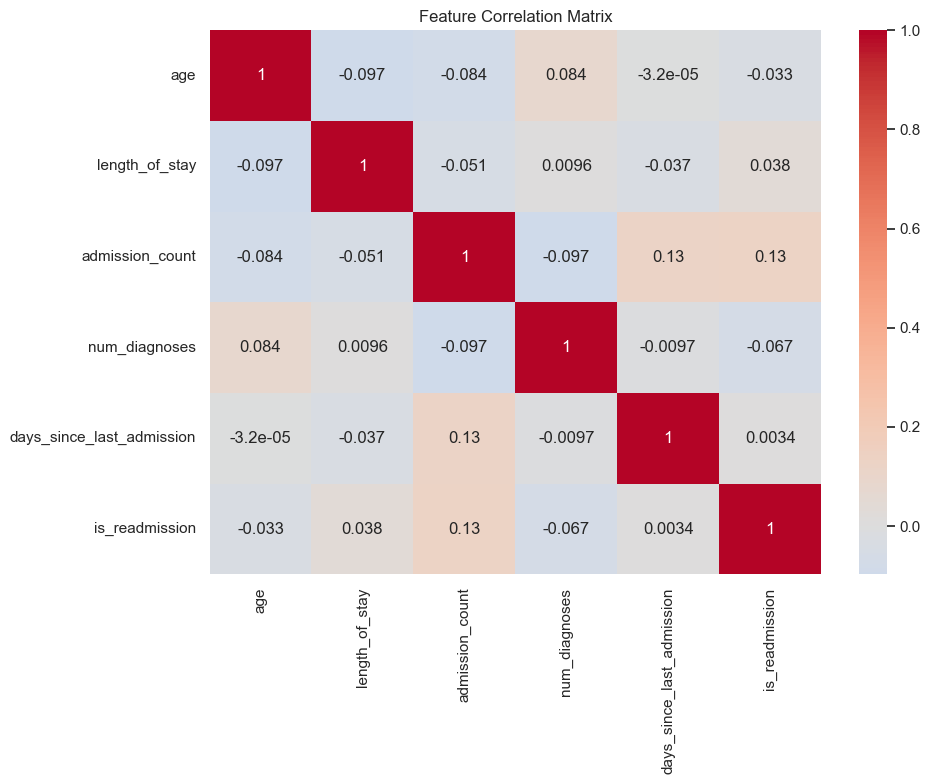

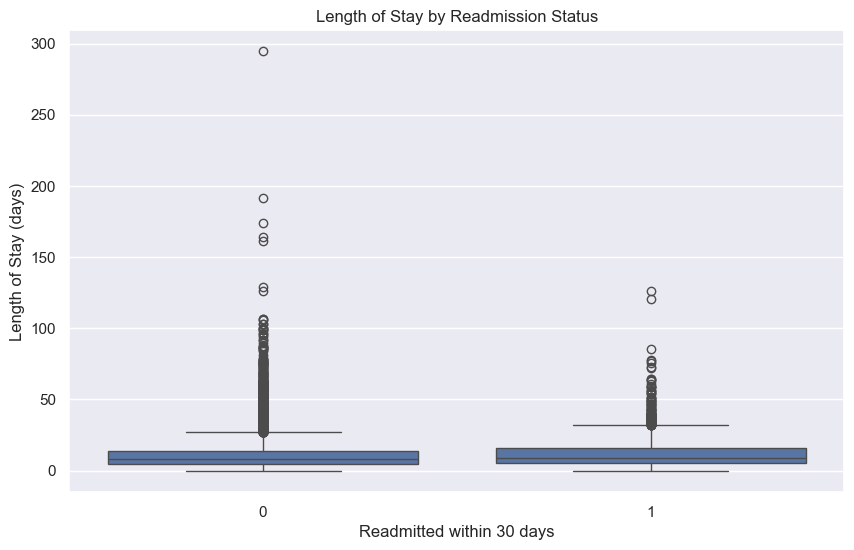

In [19]:
# Create correlation matrix
correlation_features = ['age', 'length_of_stay', 'admission_count', 
                       'num_diagnoses', 'days_since_last_admission', 'is_readmission']

plt.figure(figsize=(10, 8))
sns.heatmap(features_df[correlation_features].corr(), 
            annot=True, 
            cmap='coolwarm', 
            center=0)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Length of stay analysis
plt.figure(figsize=(10, 6))
sns.boxplot(data=features_df, x='is_readmission', y='length_of_stay')
plt.title('Length of Stay by Readmission Status')
plt.xlabel('Readmitted within 30 days')
plt.ylabel('Length of Stay (days)')
plt.show()

## 5. Comorbidity Analysis

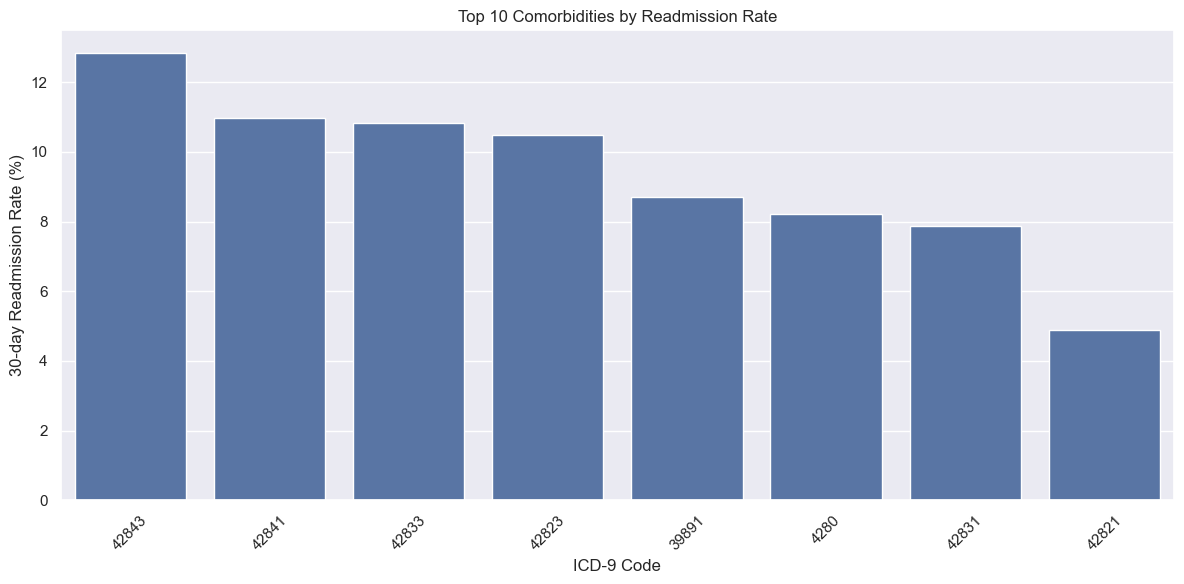


Top 10 Comorbidities with Highest Readmission Rates:
  icd9_code  total_cases  readmission_rate
7     42843          327         12.844037
6     42841           73         10.958904
5     42833         1220         10.819672
3     42823         1143         10.498688
0     39891          437          8.695652
1      4280        13111          8.206849
4     42831          432          7.870370
2     42821          492          4.878049


In [20]:
def analyze_comorbidities(diagnoses_df, features_df):
    # Merge diagnoses with readmission information
    diagnoses_with_outcome = diagnoses_df.merge(features_df[['hadm_id', 'is_readmission']], 
                                               on='hadm_id', 
                                               how='left')
    
    # Calculate readmission rate by diagnosis code
    diagnosis_readmission = diagnoses_with_outcome.groupby('icd9_code').agg({
        'is_readmission': ['count', 'mean']
    }).reset_index()
    
    diagnosis_readmission.columns = ['icd9_code', 'total_cases', 'readmission_rate']
    diagnosis_readmission['readmission_rate'] *= 100
    
    # Filter for common diagnoses (minimum 50 cases)
    common_diagnoses = diagnosis_readmission[diagnosis_readmission['total_cases'] >= 50]
    
    # Sort by readmission rate
    return common_diagnoses.sort_values('readmission_rate', ascending=False)

# Analyze comorbidities
comorbidity_analysis = analyze_comorbidities(hf_diagnoses, features_df)

# Plot top 10 comorbidities by readmission rate
plt.figure(figsize=(12, 6))
sns.barplot(data=comorbidity_analysis.head(10), 
            x='icd9_code', 
            y='readmission_rate')
plt.title('Top 10 Comorbidities by Readmission Rate')
plt.xlabel('ICD-9 Code')
plt.ylabel('30-day Readmission Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display detailed statistics
print("\nTop 10 Comorbidities with Highest Readmission Rates:")
print(comorbidity_analysis.head(10))

## 6. Temporal Patterns

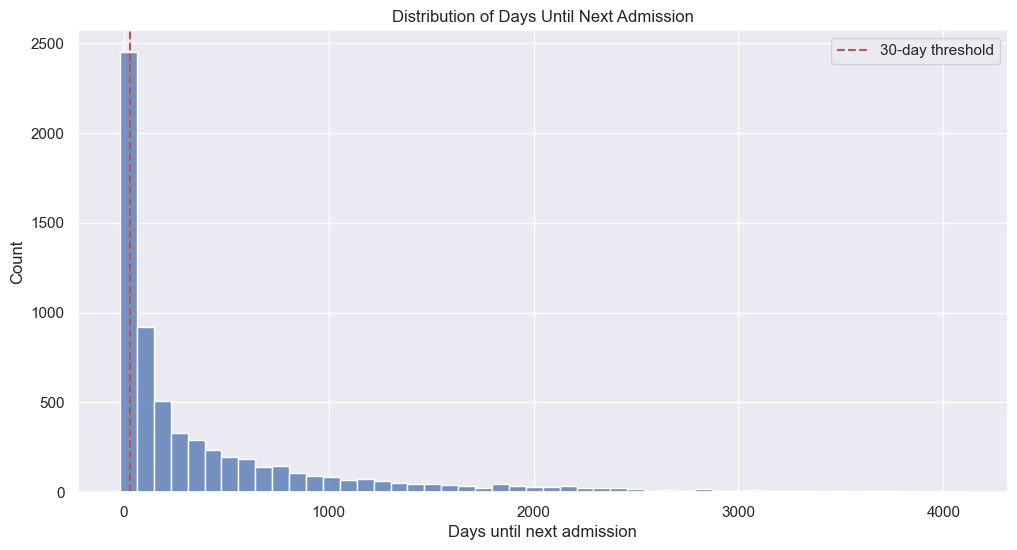

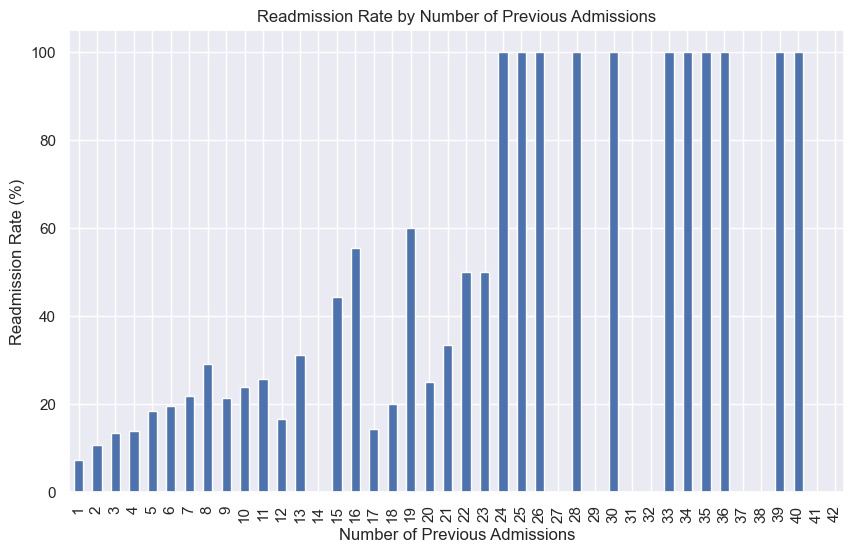

In [21]:
# Analyze readmission timing
plt.figure(figsize=(12, 6))
sns.histplot(data=features_df[features_df['days_to_next_admission'].notna()], 
             x='days_to_next_admission',
             bins=50)
plt.axvline(x=30, color='r', linestyle='--', label='30-day threshold')
plt.title('Distribution of Days Until Next Admission')
plt.xlabel('Days until next admission')
plt.ylabel('Count')
plt.legend()
plt.show()

# Analyze admission count impact
plt.figure(figsize=(10, 6))
admission_readmission = features_df.groupby('admission_count')['is_readmission'].mean() * 100
admission_readmission.plot(kind='bar')
plt.title('Readmission Rate by Number of Previous Admissions')
plt.xlabel('Number of Previous Admissions')
plt.ylabel('Readmission Rate (%)')
plt.show()

## Key Insights

1. Demographics:
   - Age distribution patterns and their relation to readmission risk
   - Gender-based differences in readmission rates

2. Clinical Patterns:
   - Correlation between length of stay and readmission risk
   - Impact of number of diagnoses on readmission probability
   - Most impactful comorbidities for readmission

3. Temporal Patterns:
   - Distribution of time between admissions
   - Effect of previous admissions on readmission risk

These insights will be valuable for feature selection in our predictive model.

## 7. Data Preprocessing for Modeling

Let's prepare our features and target variable for model training:
1. Handle missing values
2. Encode categorical features
3. Normalize numerical features
4. Create train/test split

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

def preprocess_features(features_df):
    """
    Preprocess features for modeling:
    - Handle missing values
    - Encode categorical variables
    - Normalize numerical features
    """
    # Deep copy to avoid modifying original
    df = features_df.copy()
    
    # Define feature groups
    numerical_features = ['age', 'length_of_stay', 'admission_count', 
                         'num_diagnoses', 'num_procedures', 'days_since_last_admission']
    categorical_features = ['gender'] if 'gender' in df.columns else []
    
    # Handle missing values
    numerical_imputer = SimpleImputer(strategy='mean')
    df[numerical_features] = numerical_imputer.fit_transform(df[numerical_features])
    
    if categorical_features:
        categorical_imputer = SimpleImputer(strategy='most_frequent')
        df[categorical_features] = categorical_imputer.fit_transform(df[categorical_features])
    
    # Encode categorical variables
    if categorical_features:
        df = pd.get_dummies(df, columns=categorical_features, drop_first=True)
    
    # Normalize numerical features
    scaler = StandardScaler()
    df[numerical_features] = scaler.fit_transform(df[numerical_features])
    
    return df

# Prepare features and target
print("Preprocessing features...")
X = preprocess_features(features_df)
y = features_df['is_readmission']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nDataset shapes:")
print(f"Training set: {X_train.shape} samples, {X_train.shape[1]} features")
print(f"Testing set: {X_test.shape} samples, {X_test.shape[1]} features")
print(f"\nClass distribution in training set:")
print(y_train.value_counts(normalize=True).round(3))